In [1]:
import os
os.chdir('../')
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.features.comparison_utils import get_similar_pairs, SHORTCUTS

from src.visualization.plot_utils import plot_effect_types, get_comparison_plots

from src.features.covid_spread_utils import get_max_covid_corr
import notebooks.config as experim_cfg

In this study, we considered two approaches to determine the similarity of countries. The first - a measure of distance, calculated on some covid parameters. In the second case, we selected countries with the highest correlation of morbidity and mortality trends between countries.

## Custom similarity distance

In this case, we are looking for pairs of countries with the **smallest distance**. This parameter includes the following covid indicators:

Must be different (vaccination parameters):
 - 'delta_days_to_10%',
 - 'delta_days_to_25%',
 - 'delta_days_to_50%',
 - 'delta_mean_vac_rate',
 
Must be the same (covid parameters):
 - 'delta_first_lambda_lt_0.02',
 - 'delta_covid_start_date',
 - 'delta_mean_lambda',
 
The realization of this comparison is in /src/features/comparison_utils.py

In [2]:
comparisons_stats_path = Path(
    'data',
    'processed',
    f'all_counties_comparisons({experim_cfg.MORTALITY_INDICATOR}).csv',
)
all_countries_comparisons = pd.read_csv(comparisons_stats_path)

In [3]:
covid_df_for_DID_path = Path(
    'data',
    'interim',
    f'covid_df_for_DID_({experim_cfg.MORTALITY_INDICATOR}).csv',
)
covid_df_for_DID = pd.read_csv(covid_df_for_DID_path)
covid_df_for_DID['date'] = pd.to_datetime(covid_df_for_DID['date'])

In [4]:
all_countries_comparisons

iso_code_1 iso_code_2  delta_covid_start_date  delta_vac_start_date  \
0           ALB        ABW                      -4                   -78   
1           ALB        AUS                      43                   -42   
2           ALB        AUT                      13                    14   
3           ALB        AZE                       8                    -7   
4           ALB        BEL                      34                    13   
...         ...        ...                     ...                   ...   
2140        THA        GBR                      -9                    48   
2141        THA        USA                       0                    76   
2142        UKR        GBR                      32                    45   
2143        UKR        USA                      41                    73   
2144        GBR        USA                       9                    28   

      same_cluster  same_corr_quadrant  same_continent  \
0            False               False           False   
1             True               False           False   
2            False               False            True   
3            False                True           False   
4            False               False            True   
...            ...                 ...             ...   
2140          True               False           False   
2141          True               False           False   
2142          True               False            True   
2143          True               False           False   
2144          True                True           False   

      delta_n_monotonic_region  delta_mean_lambda  delta_mean_vac_rate  ...  \
0                         -3.0           0.015904              -0.0812  ...   
1                         -4.0           0.007438              -0.0753  ...   
2                         -1.0          -0.001271              -0.0468  ...   
3                         -1.0           0.002919              -0.0097  ...   
4                         -3.0           0.007926              -0.0510  ...   
...                        ...                ...                  ...  ...   
2140                       6.0          -0.012881               0.0103  ...   
2141                       5.0          -0.013652               0.0170  ...   
2142                       0.0          -0.005476              -0.0667  ...   
2143                      -1.0          -0.006247              -0.0600  ...   
2144                      -1.0          -0.000770               0.0067  ...   

      VacRate_effect_25%_vac-150d_BV  DID_50%_vac-90d_BV  \
0                                bad                 NaN   
1                                bad                 NaN   
2                                bad                 NaN   
3                               good                 NaN   
4                               good                 NaN   
...                              ...                 ...   
2140                            good           28.238333   
2141                            good           17.519936   
2142                            good                 NaN   
2143                            good                 NaN   
2144                            good          -10.718397   

      VacRate_effect_50%_vac-90d_BV  Vac_effect_50%_vac-90d_BV  \
0                               NaN                        NaN   
1                               NaN                        NaN   
2                               NaN                        NaN   
3                               NaN                        NaN   
4                               NaN                        NaN   
...                             ...                        ...   
2140                           good                       diff   
2141                           good                       diff   
2142                            NaN                        NaN   
2143                            NaN                        NaN   

In [5]:
most_similar_countries = get_similar_pairs(
    comparison_df=all_countries_comparisons,
    n_countries=20,  
)

In [6]:
parameters_variation_path = Path(
    'data',
    'processed',
    f'most_similar_countries(CustomSD-{experim_cfg.MORTALITY_INDICATOR}).csv',
)
most_similar_countries.to_csv(parameters_variation_path, index=False)

<AxesSubplot:xlabel='max_EM_corr', ylabel='max_NCSPM_corr'>

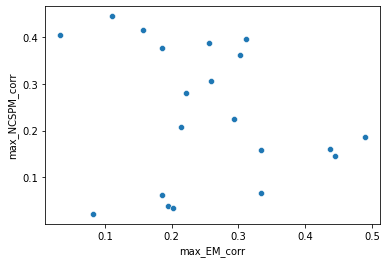

In [7]:
sns.scatterplot(
    data=most_similar_countries,
    x=f'max_{SHORTCUTS[experim_cfg.MORTALITY_INDICATOR]}_corr',
    y='max_NCSPM_corr',
)

### Considering the most similar pairs

In [8]:
all_countries_comparisons['iso_codes'] = (
    all_countries_comparisons['iso_code_1'] + '_' +
    all_countries_comparisons['iso_code_2']
)

In [9]:
most_common_pairs_df = all_countries_comparisons[
    all_countries_comparisons['iso_codes'].isin(most_similar_countries['iso_codes'])
]

<Figure size 720x720 with 0 Axes>

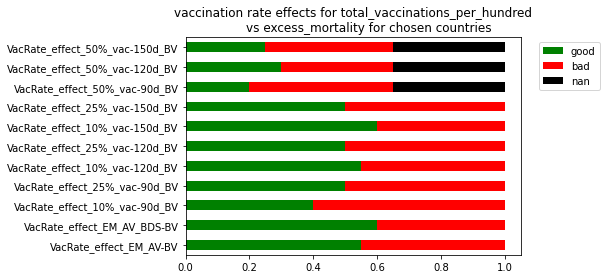

In [10]:
plot_effect_types(
    comparison_df=most_common_pairs_df,
    effect_type='vaccination rate',
    vaccination_indicator=experim_cfg.VACCINATION_INDICATOR,
    mort_indicator=experim_cfg.MORTALITY_INDICATOR,
)

<Figure size 720x720 with 0 Axes>

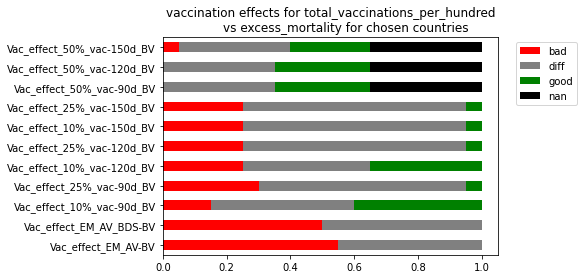

In [11]:
plot_effect_types(
    comparison_df=most_common_pairs_df,
    effect_type='vaccination',
    vaccination_indicator=experim_cfg.VACCINATION_INDICATOR,
    mort_indicator=experim_cfg.MORTALITY_INDICATOR,
)

### Comparison plots

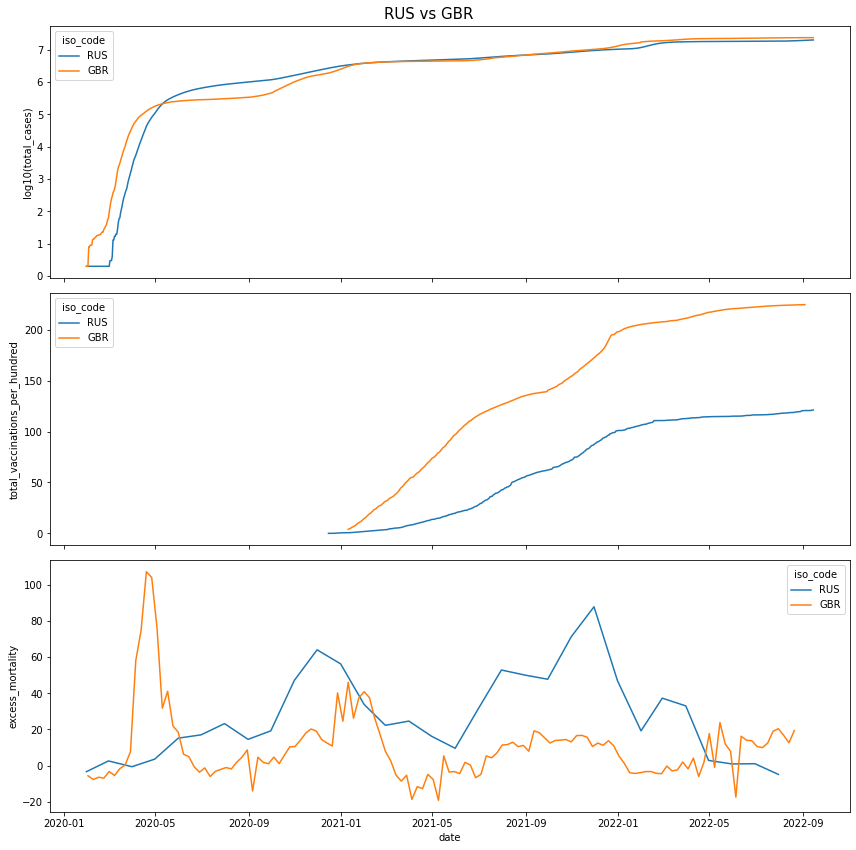

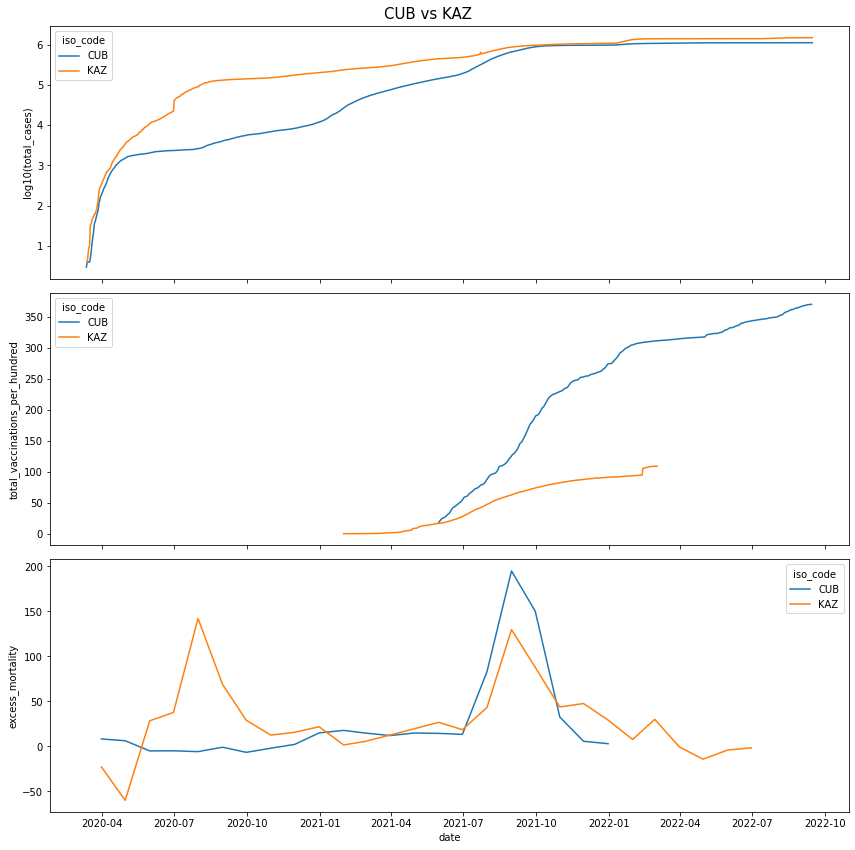

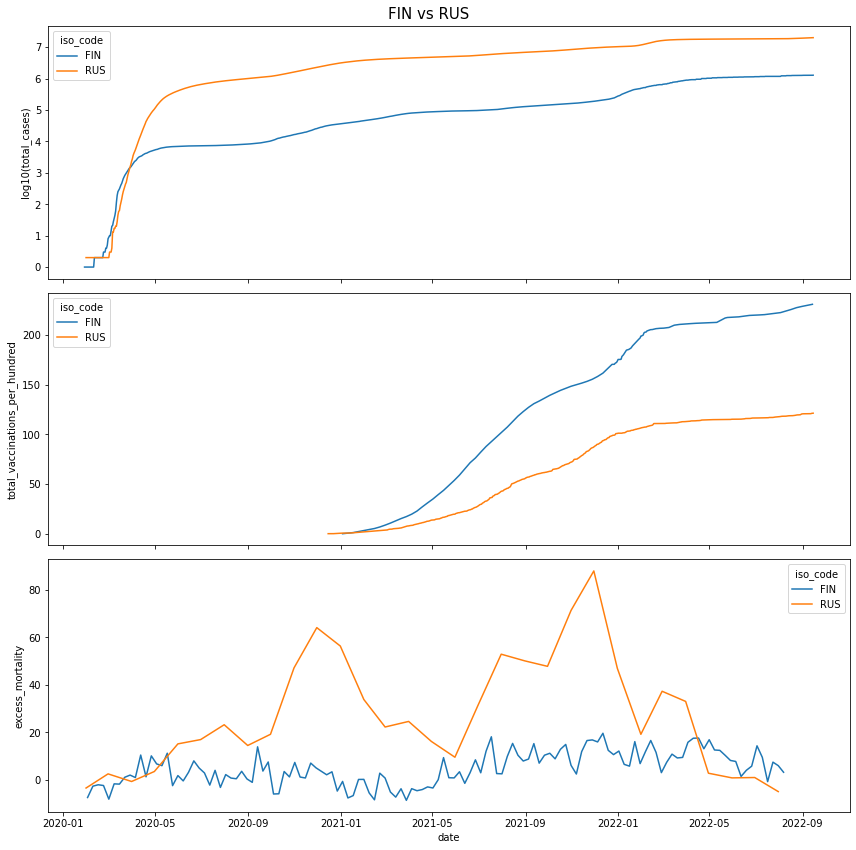

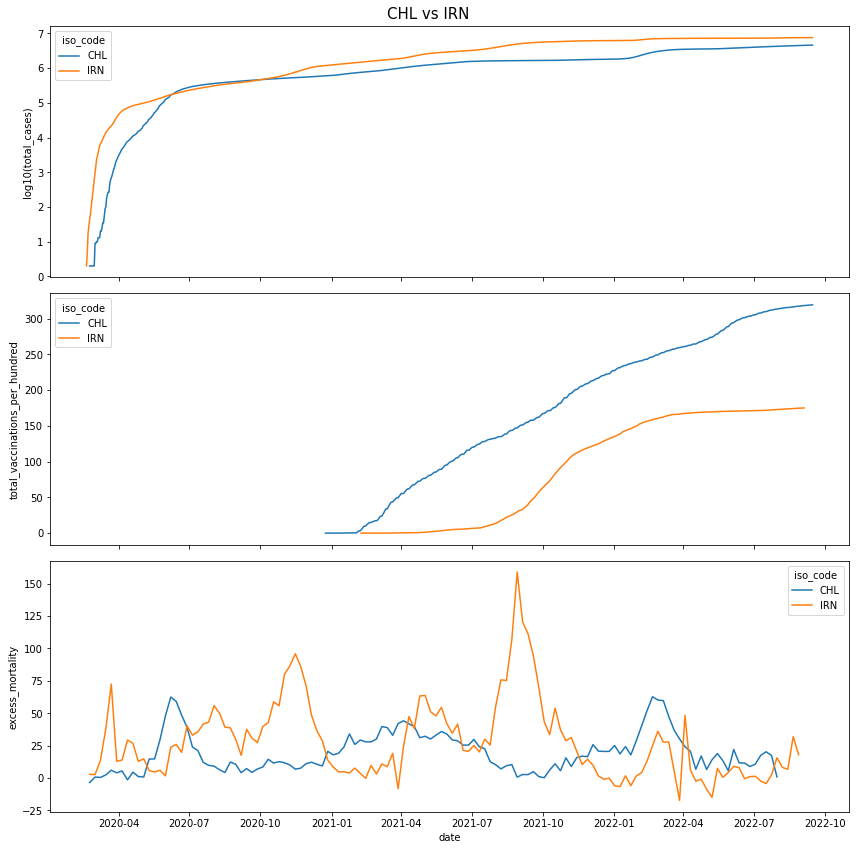

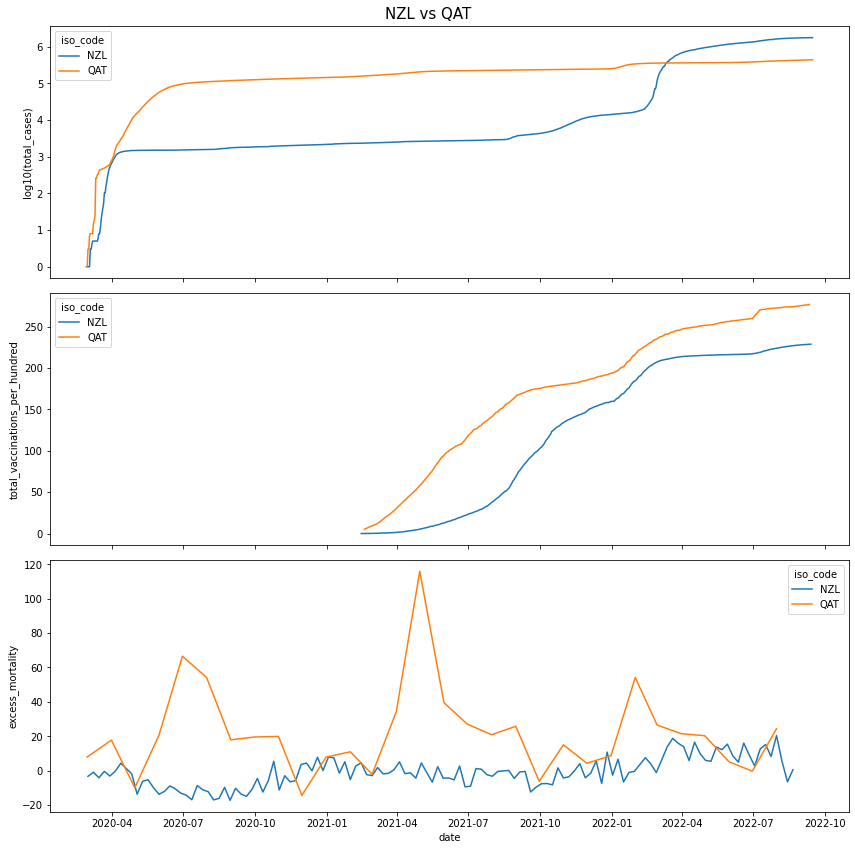

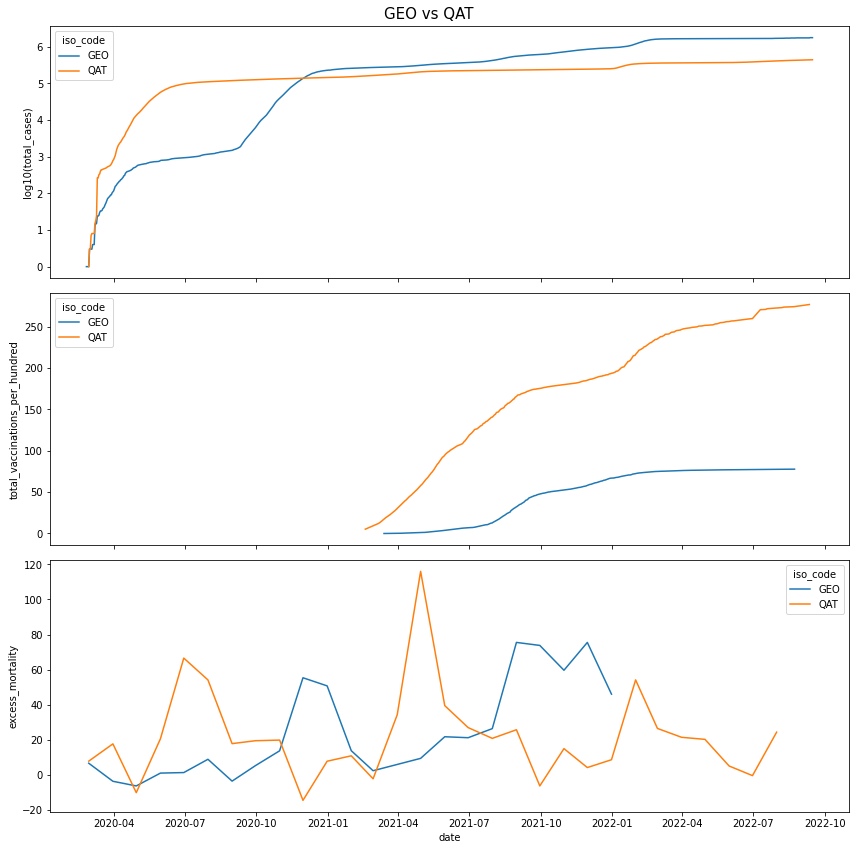

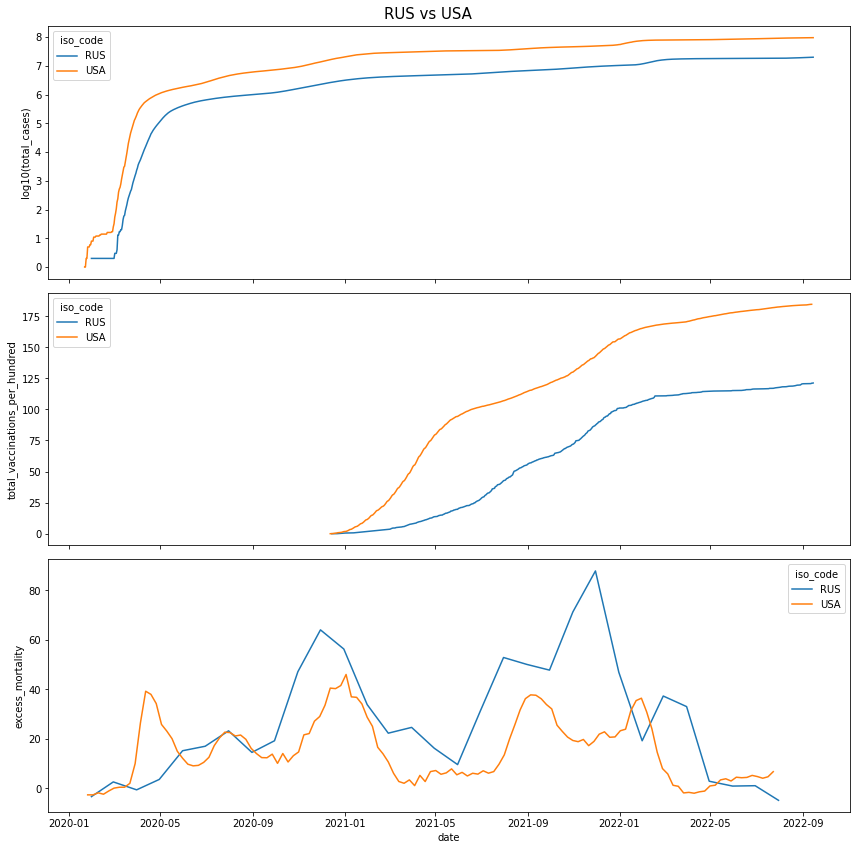

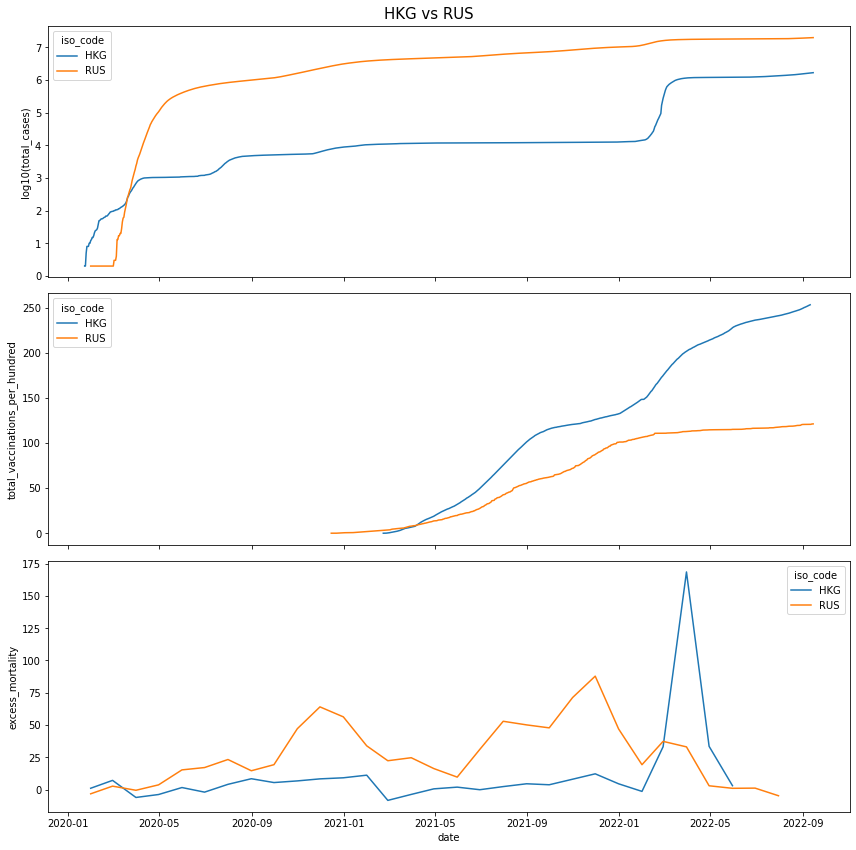

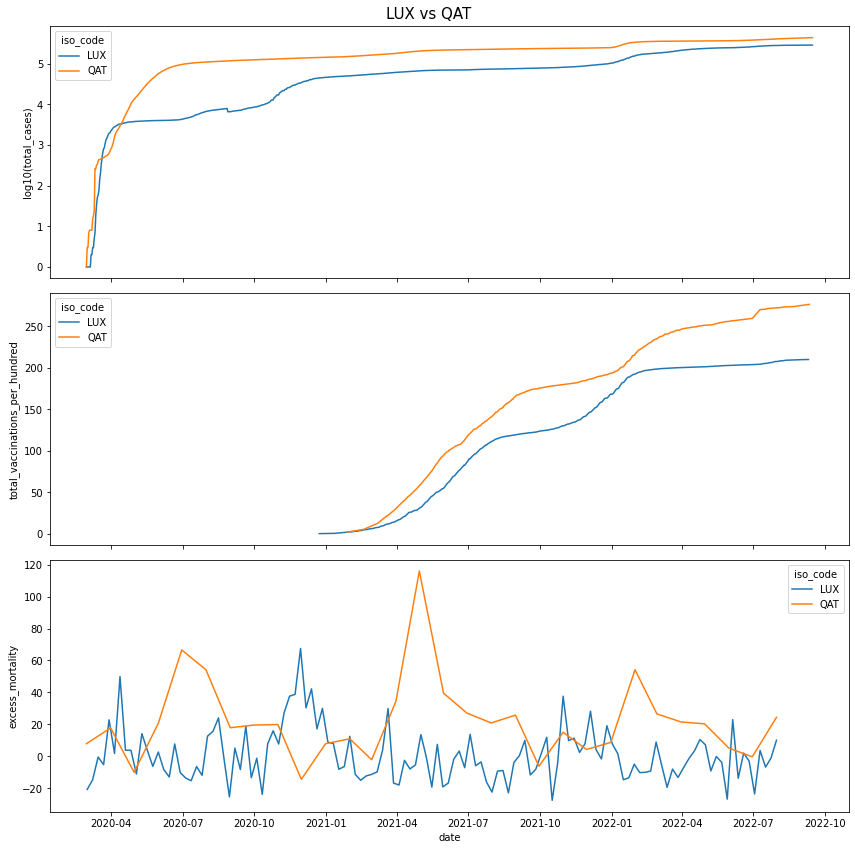

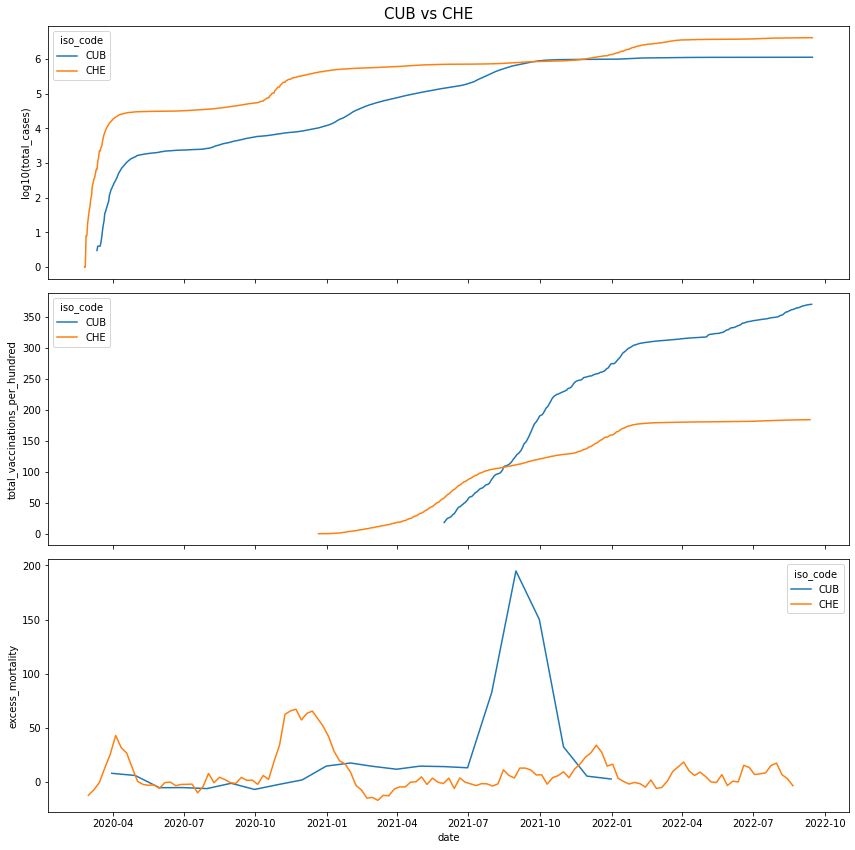

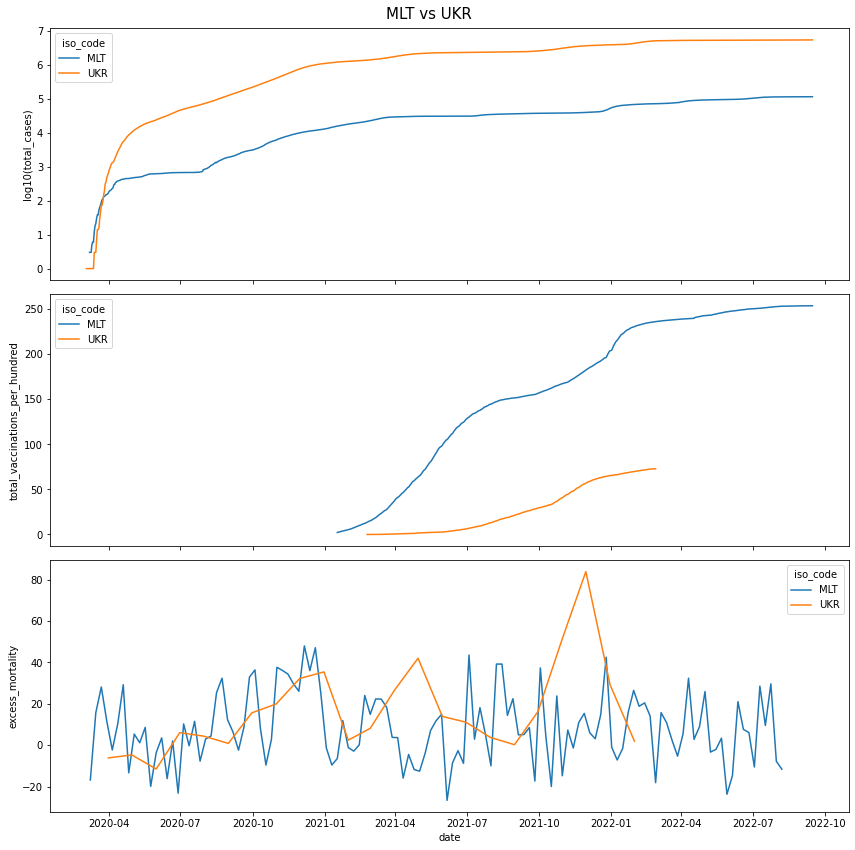

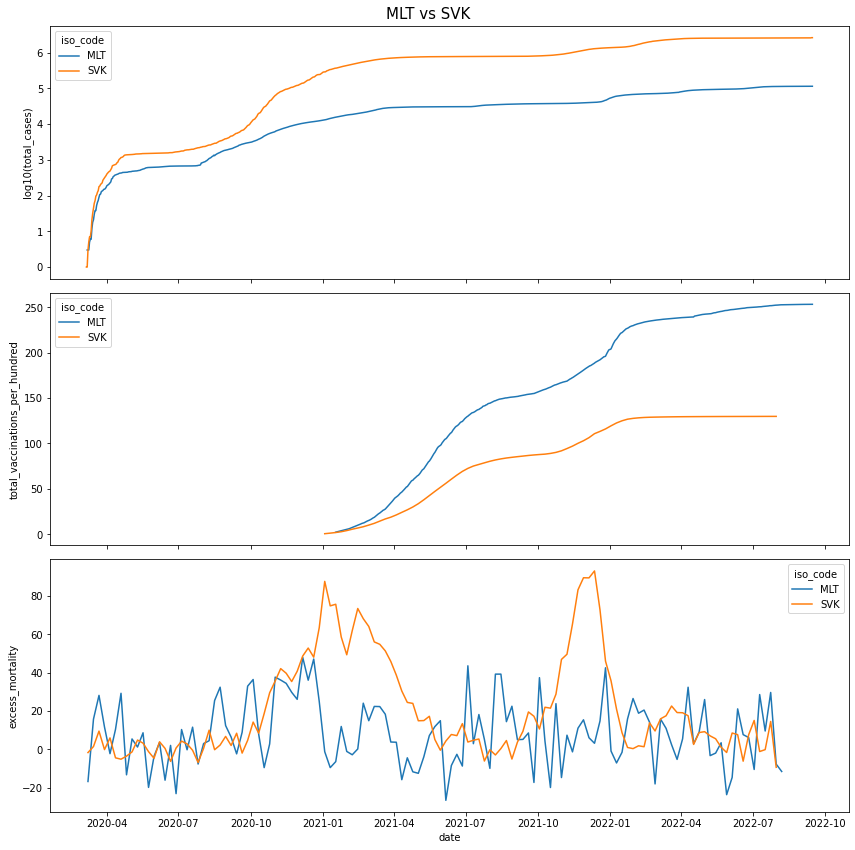

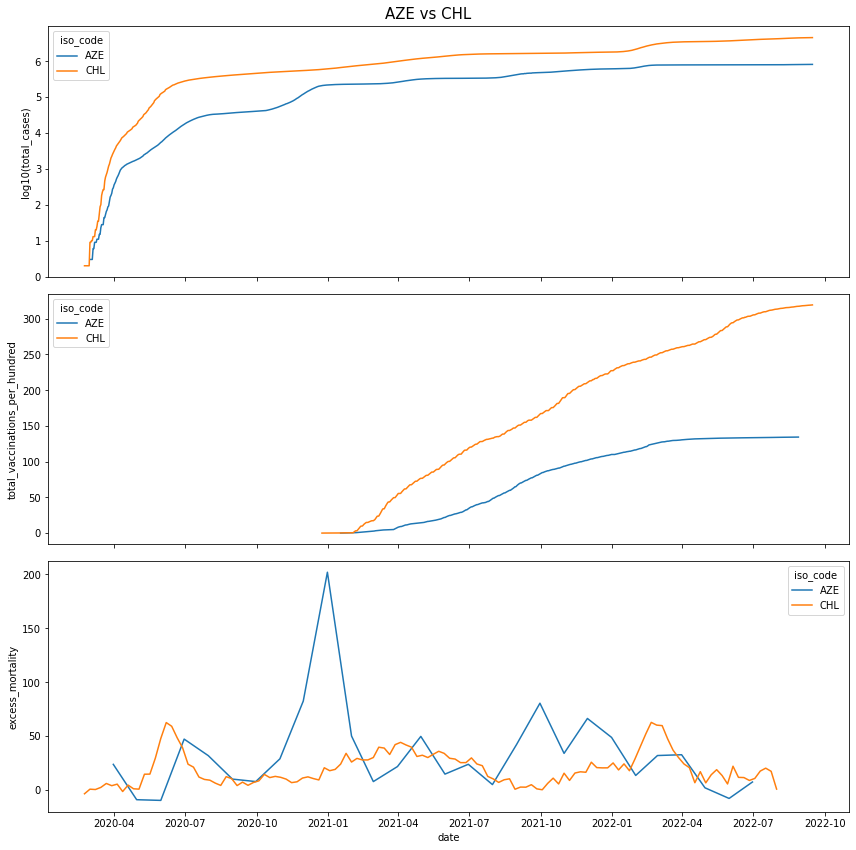

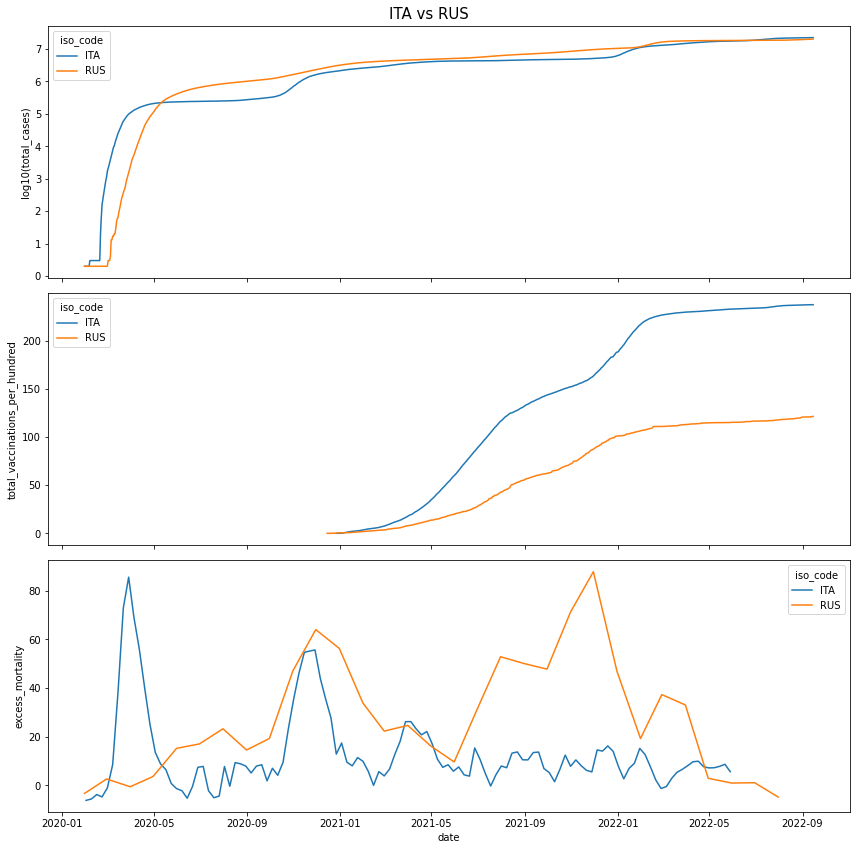

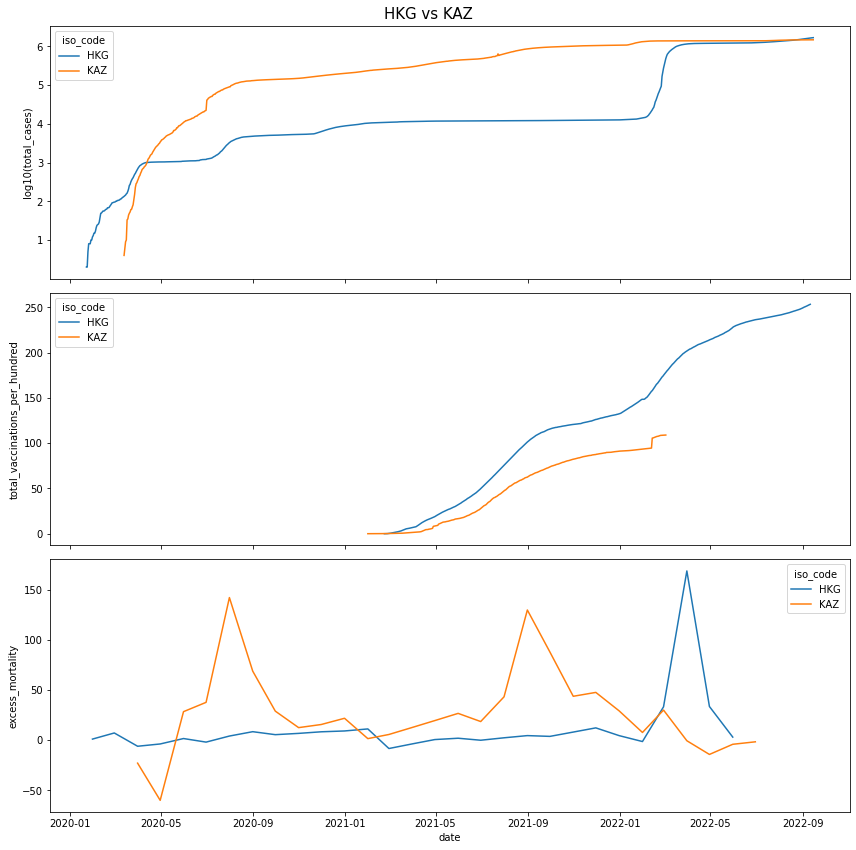

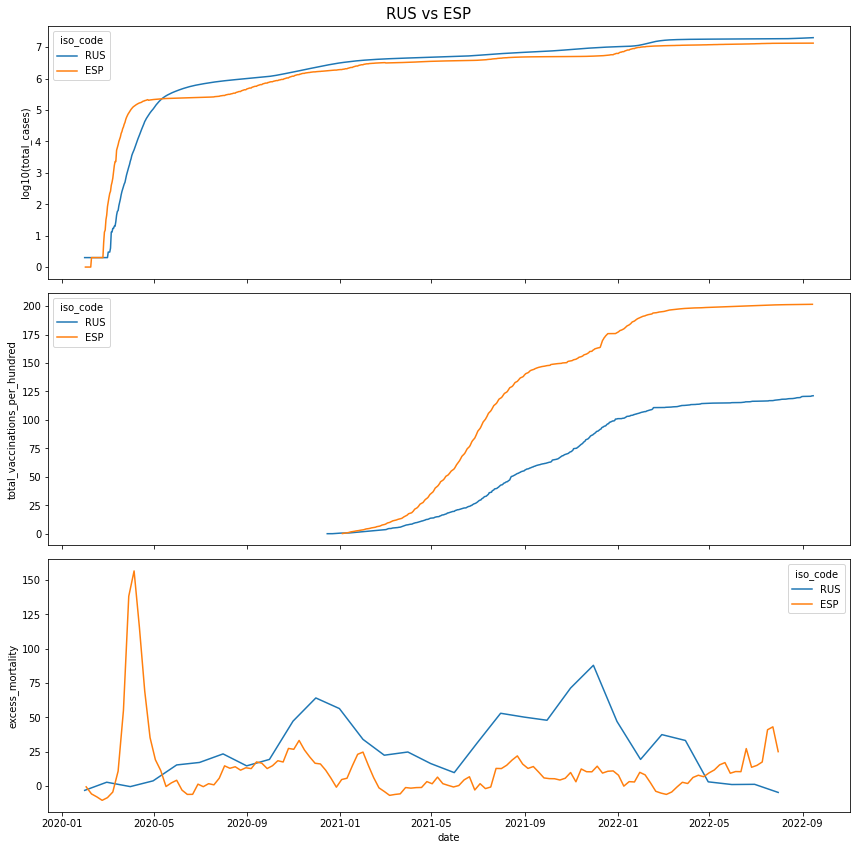

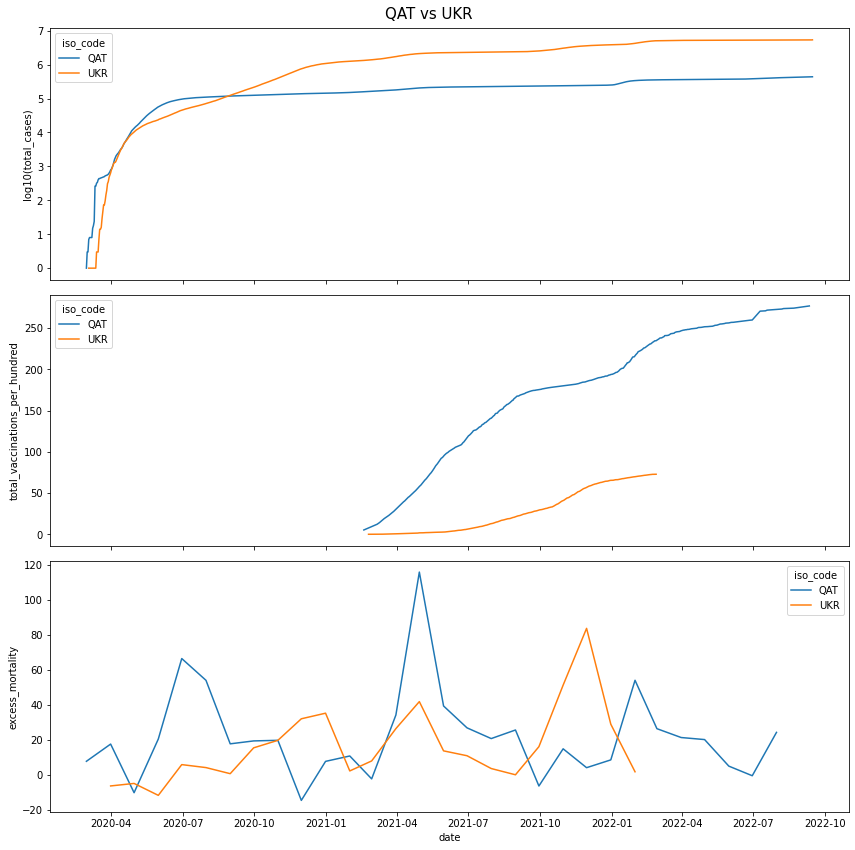

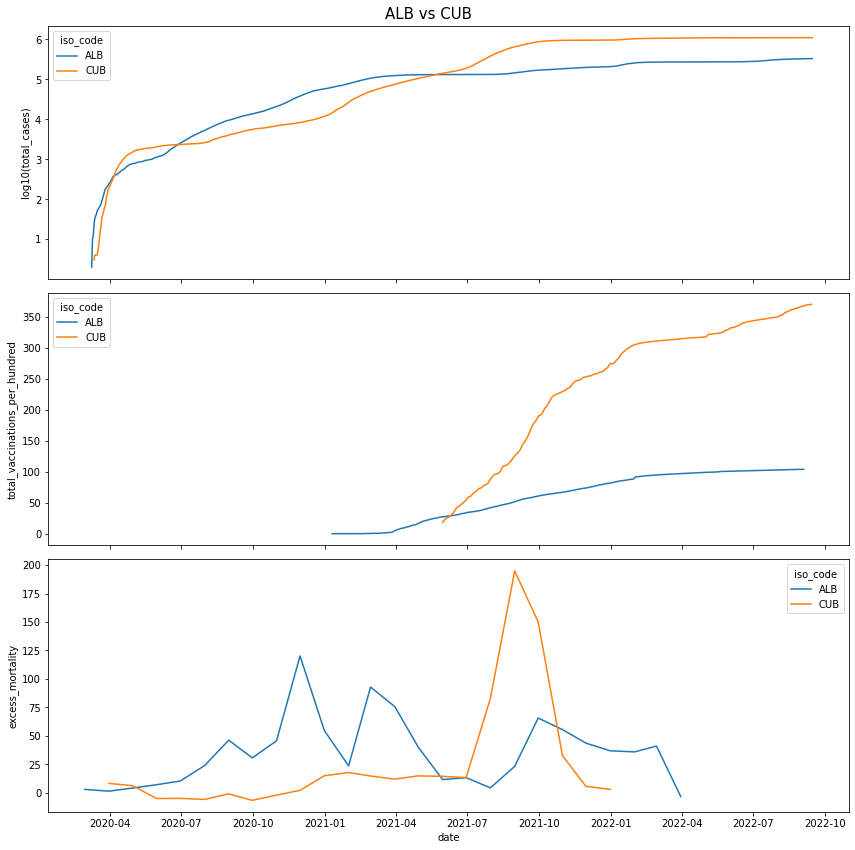

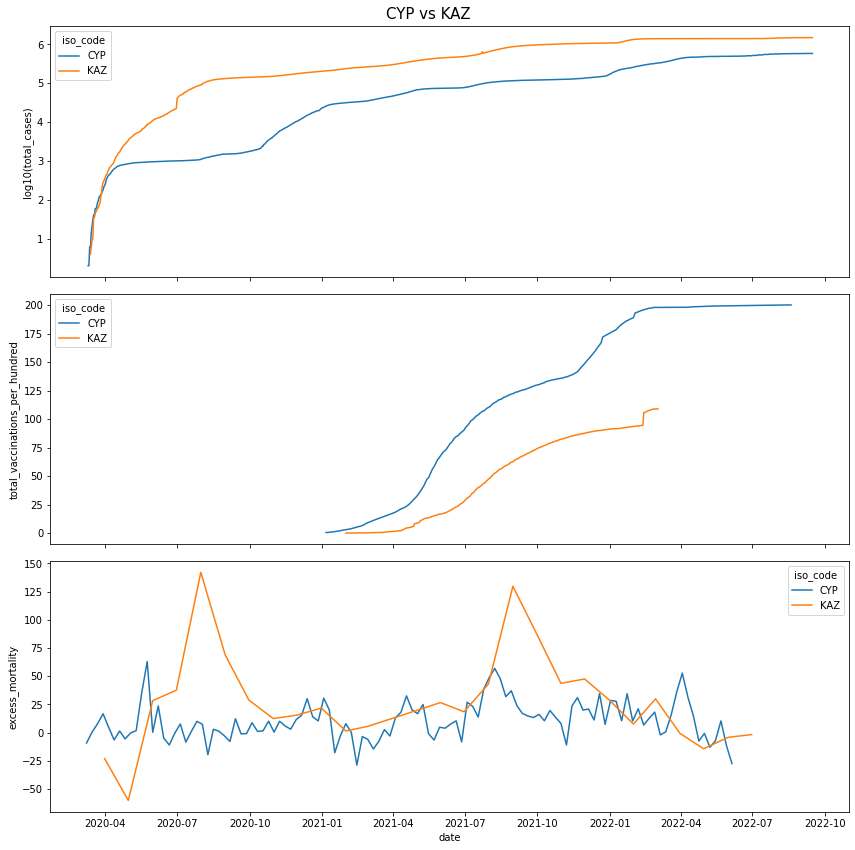

In [12]:
for pair in most_similar_countries[['iso_code_1', 'iso_code_2']].values:
    get_comparison_plots(
        covid_df=covid_df_for_DID,
        iso_code_1=pair[0],
        iso_code_2=pair[1],
        vaccination_indicator=experim_cfg.VACCINATION_INDICATOR,
        mort_indicators=[experim_cfg.MORTALITY_INDICATOR],
        save_plot=False,
    )

## Correlation of  morbidity and mortality trends

We've decided to consider new_cases_smoothed_per_million as covid spread rate parameter. The realization is presented in src/features/comparison_utils.py

In [13]:
corr_similar_countries = all_countries_comparisons[
    (all_countries_comparisons.max_NCSPM_corr > 0.55) &
    (all_countries_comparisons[f'max_{SHORTCUTS[experim_cfg.MORTALITY_INDICATOR]}_corr'] > 0.55) &
    (all_countries_comparisons.same_cluster == True)
].copy()

In [14]:
parameters_variation_path = Path(
    'data',
    'processed',
    f'most_similar_countries(CorrSD-{experim_cfg.MORTALITY_INDICATOR}).csv',
)
corr_similar_countries.to_csv(parameters_variation_path, index=False)

<AxesSubplot:xlabel='max_EM_corr', ylabel='max_NCSPM_corr'>

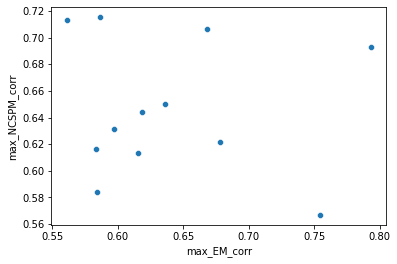

In [15]:
sns.scatterplot(
    data=corr_similar_countries,
    x=f'max_{SHORTCUTS[experim_cfg.MORTALITY_INDICATOR]}_corr',
    y='max_NCSPM_corr',
)

In [16]:
print(f'{corr_similar_countries.shape[0]} countries were chosen as the most similar')

12 countries were chosen as the most similar


In [17]:
corr_similar_countries.iso_codes.values

array(['AUT_BGR', 'AUT_ROU', 'AUT_SVN', 'AZE_ZAF', 'BGR_GRC', 'BGR_POL',
       'BGR_ROU', 'BGR_SRB', 'CZE_POL', 'ITA_CHE', 'ITA_GBR', 'POL_SRB'],
      dtype=object)

In [18]:
corr_similar_countries.same_cluster.value_counts()

True    12
Name: same_cluster, dtype: int64

In [19]:
corr_similar_countries

iso_code_1 iso_code_2  delta_covid_start_date  delta_vac_start_date  \
196         AUT        BGR                     -12                    -2   
239         AUT        ROU                      -1                     0   
244         AUT        SVN                      -9                     0   
306         AZE        ZAF                      -4                   -30   
506         BGR        GRC                      11                     1   
532         BGR        POL                       4                     1   
534         BGR        ROU                      11                     2   
536         BGR        SRB                       2                   -10   
903         CZE        POL                      -3                    -1   
1545        ITA        CHE                     -25                     6   
1548        ITA        GBR                       0                   -14   
2012        POL        SRB                      -2                   -11   

      same_cluster  same_corr_quadrant  same_continent  \
196           True                True            True   
239           True               False            True   
244           True               False            True   
306           True               False           False   
506           True                True            True   
532           True               False            True   
534           True               False            True   
536           True                True            True   
903           True               False            True   
1545          True               False            True   
1548          True                True            True   
2012          True               False            True   

      delta_n_monotonic_region  delta_mean_lambda  delta_mean_vac_rate  ...  \
196                        0.0           0.000181               0.0743  ...   
239                        0.0           0.000808               0.0556  ...   
244                       -1.0          -0.000294               0.0279  ...   
306                        1.0          -0.008156               0.0208  ...   
506                       -2.0           0.002030              -0.0724  ...   
532                        0.0          -0.005960              -0.0462  ...   
534                        0.0           0.000627              -0.0187  ...   
536                        0.0          -0.000066              -0.0306  ...   
903                        0.0          -0.001183               0.0108  ...   
1545                       0.0          -0.005433               0.0262  ...   
1548                       1.0          -0.001445               0.0064  ...   
2012                       0.0           0.005894               0.0156  ...   

      DID_50%_vac-90d_BV  VacRate_effect_50%_vac-90d_BV  \
196                  NaN                            NaN   
239                  NaN                            NaN   
244             6.691154                            bad   
306                  NaN                            NaN   
506                  NaN                            NaN   
532                  NaN                            NaN   
534                  NaN                            NaN   
536                  NaN                            NaN   
903           -13.279936                           good   
1545            9.893205                            bad   
1548           -5.126667                            bad   
2012                 NaN                            NaN   

      Vac_effect_50%_vac-90d_BV  DID_50%_vac-120d_BV  \
196                         NaN                  NaN   
239                         NaN                  NaN   
244                        good             1.778824   
306                         NaN                  NaN   
506                         NaN                  NaN   
532                         NaN                  NaN   
534                         NaN                  NaN   
536              

### Considering the most similar pairs

In [20]:
plot_effect_types(
    comparison_df=corr_similar_countries,
    effect_type='vaccination rate',
    vaccination_indicator=experim_cfg.VACCINATION_INDICATOR,
    mort_indicator=experim_cfg.MORTALITY_INDICATOR,
)

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

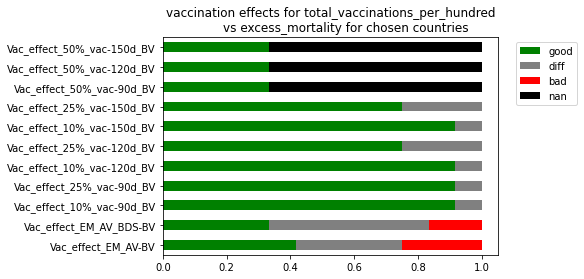

In [21]:
plot_effect_types(
    comparison_df=corr_similar_countries,
    effect_type='vaccination',
    vaccination_indicator=experim_cfg.VACCINATION_INDICATOR,
    mort_indicator=experim_cfg.MORTALITY_INDICATOR,
)

### Comparison plots

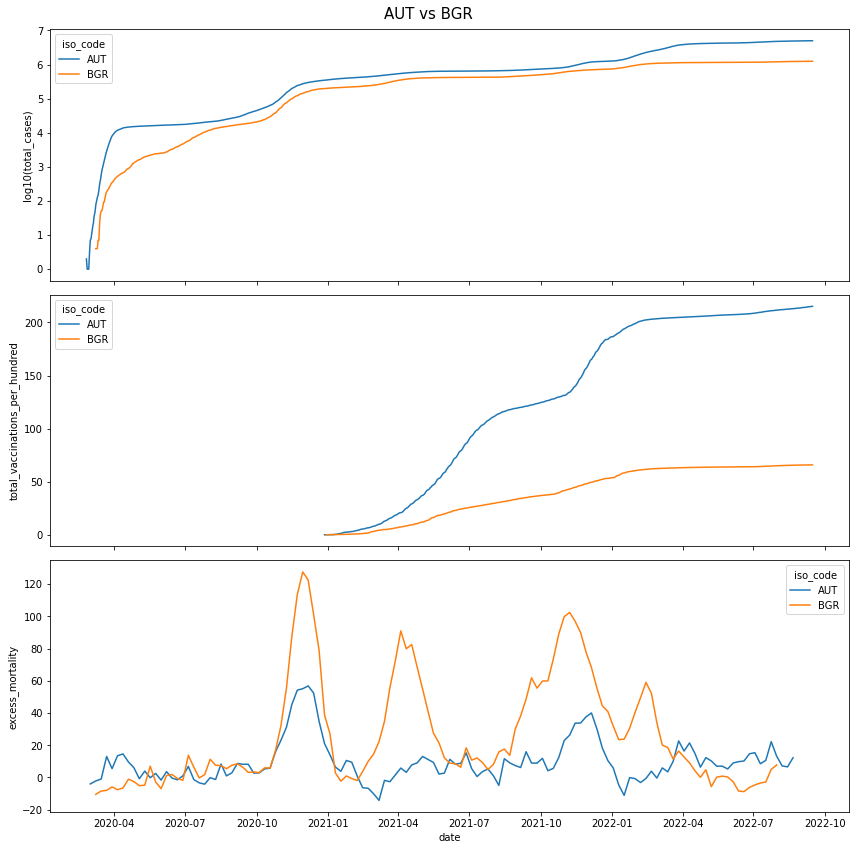

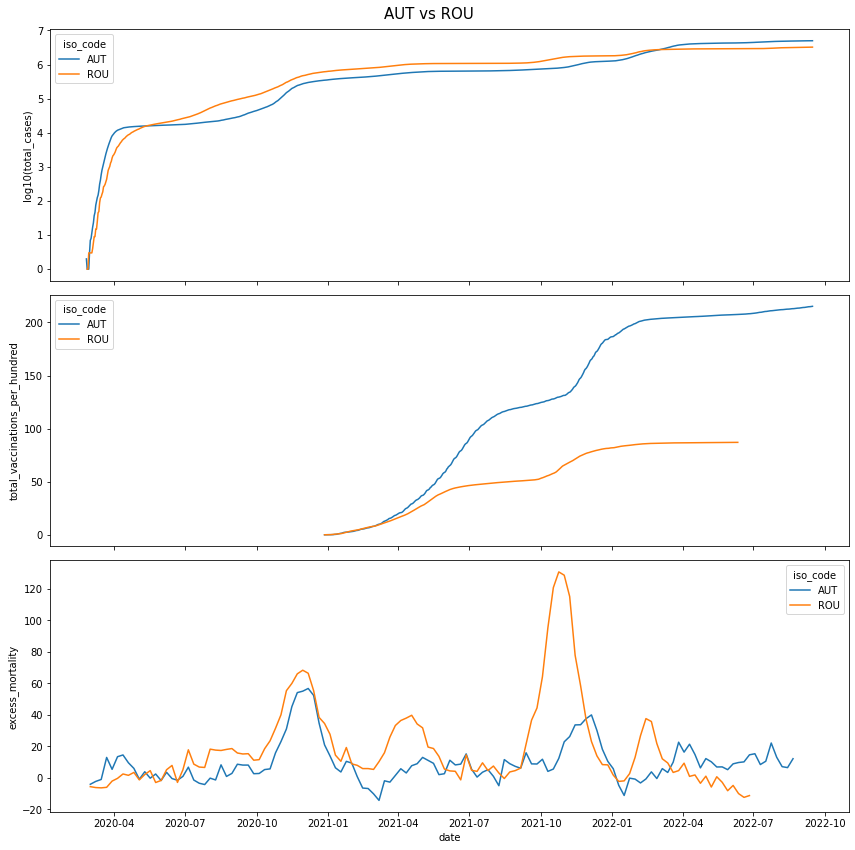

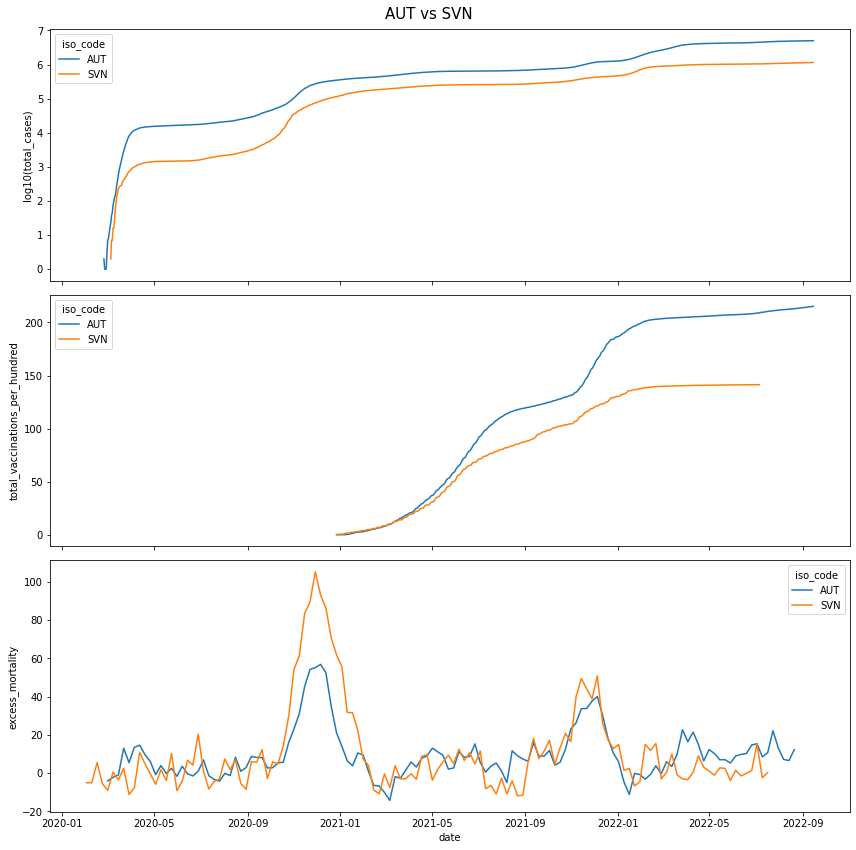

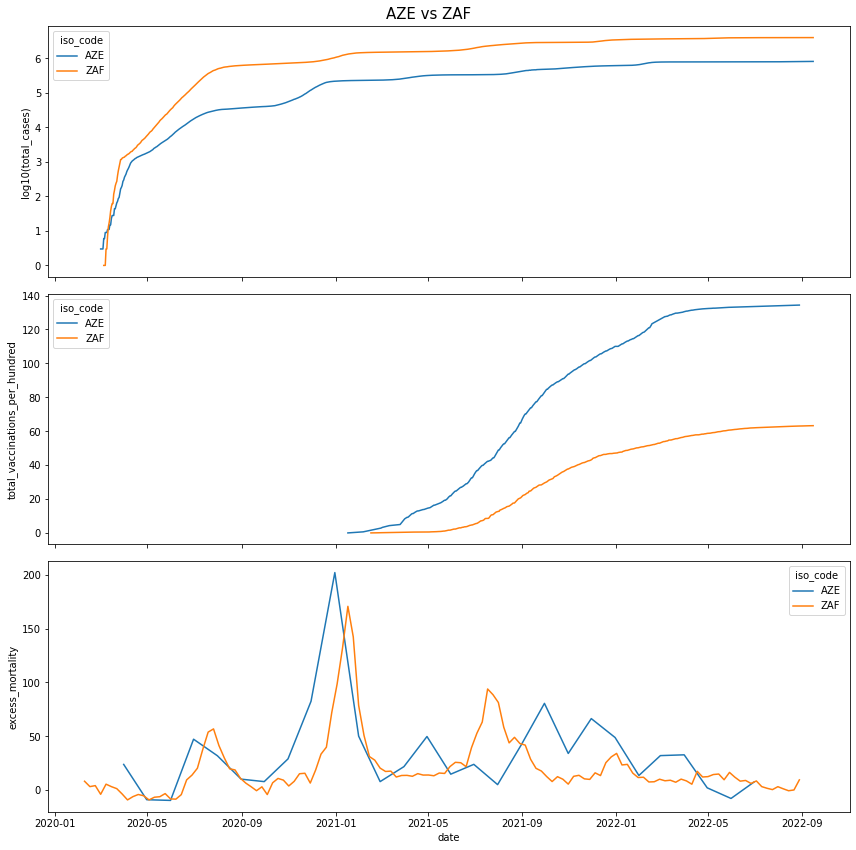

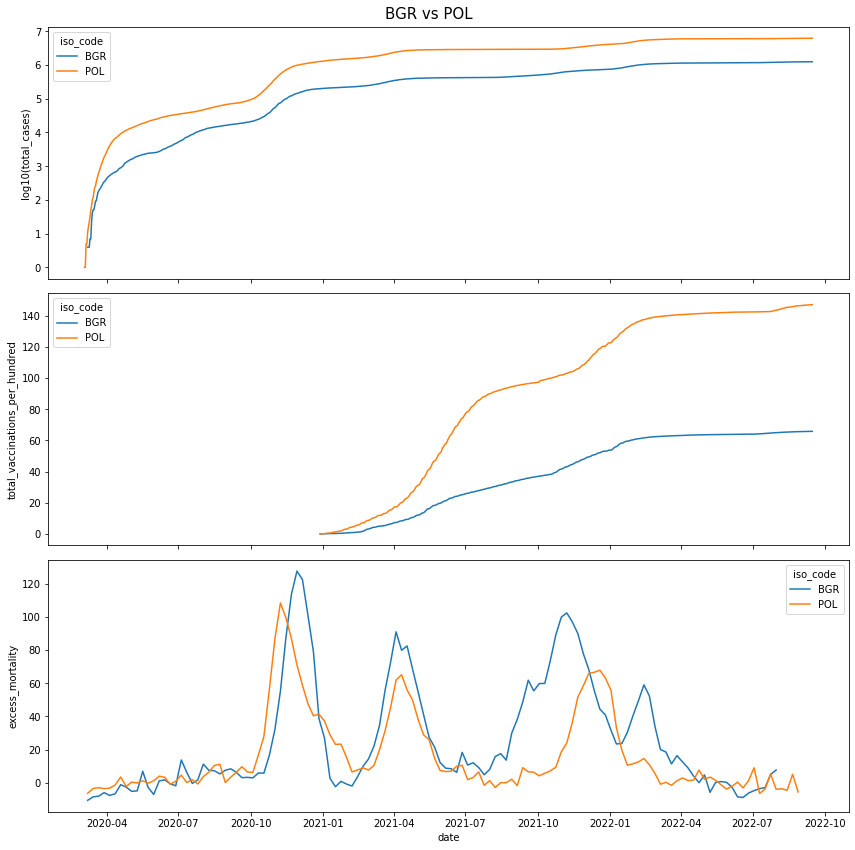

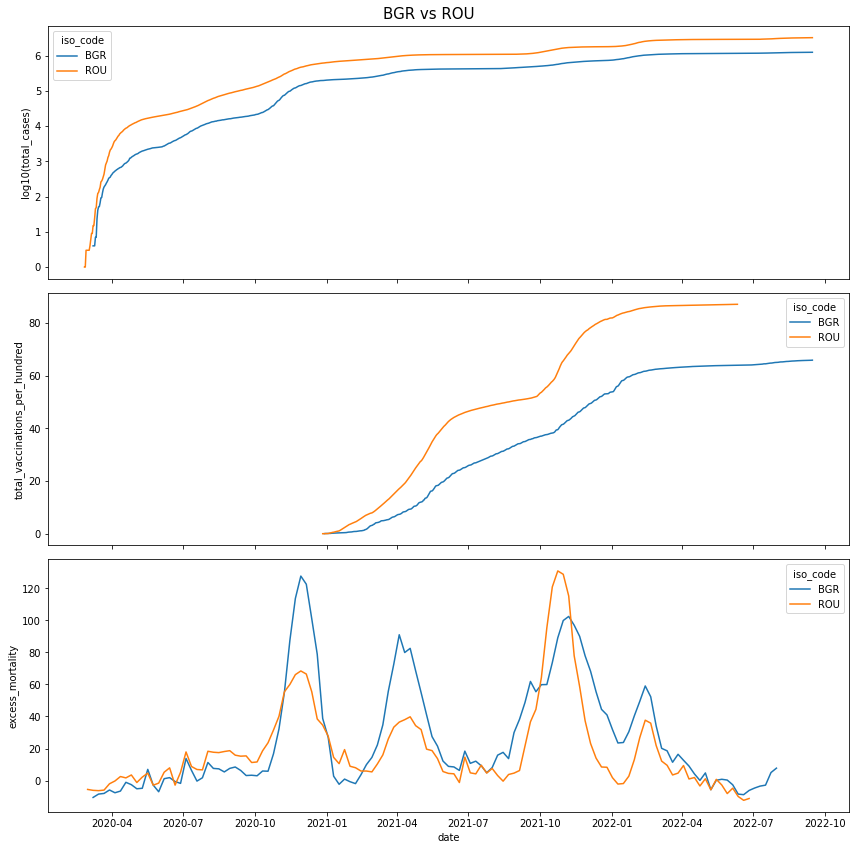

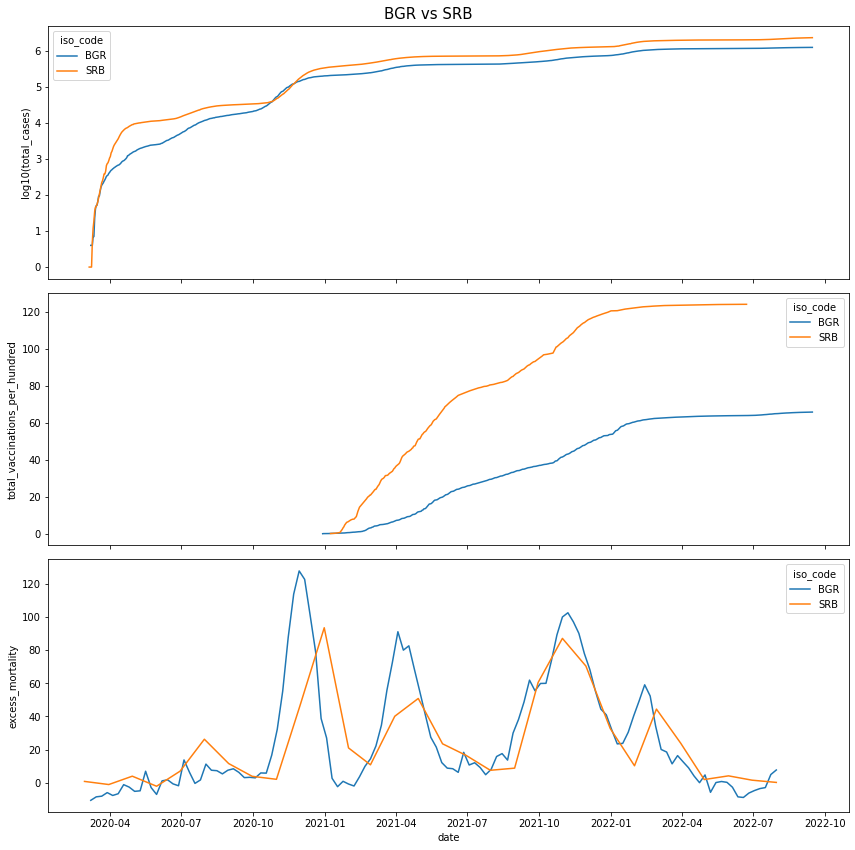

In [24]:
for pair in corr_similar_countries[['iso_code_1', 'iso_code_2']].values:
    get_comparison_plots(
        covid_df=covid_df_for_DID,
        iso_code_1=pair[0],
        iso_code_2=pair[1],
        vaccination_indicator=experim_cfg.VACCINATION_INDICATOR,
        mort_indicators=[experim_cfg.MORTALITY_INDICATOR],
        save_plot=False,
    )